In [1]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from matplotlib.ticker import MultipleLocator

from my_tools import cal_ninoskill2, runmean

In [2]:
var_pre = np.load("../data/cut_var_pred.npy")
var_pre.shape

(20, 473, 9, 51, 120)

In [3]:
var_true = np.load("../data/cut_var_true.npy")
var_true.shape

(473, 9, 51, 120)

In [4]:
nino_pre = np.load("../data/cut_nino_pred.npy")
nino_pre.shape

(20, 473)

In [5]:
nino_true = np.load("../data/cut_nino_true.npy")
nino_true.shape

(473,)

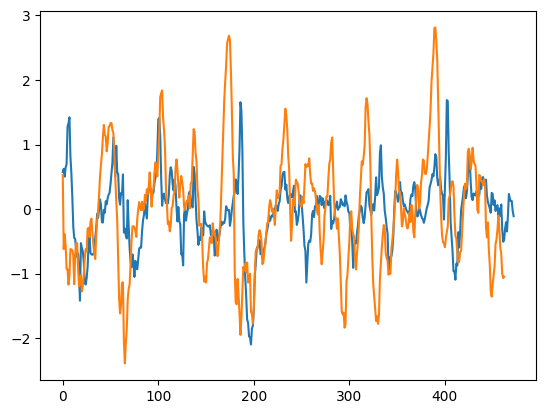

In [6]:
plt.plot(nino_pre[10,:])
plt.plot(nino_true[10:])

In [7]:
def field_corr(field1, field2):
    """
    field1: time, nspace
    field2: time, nspace
    """
    field1a = field1 - field1.mean(axis=0)
    field2a = field2 - field2.mean(axis=0)
    covar = np.einsum("ij...,ij...->j...", field1a, field2a) / (field1a.shape[0] - 1)  # covar:nspace
    corr = covar / np.std(field1a, axis=0) / np.std(field2a, axis=0)  # corr: nspace
    return corr.real

In [8]:
lead_max = 20
cut_nino_true_jx = deepcopy(nino_true[(24 - lead_max + 1) :])
cut_nino_pred_jx = deepcopy(nino_pre[:, (24 - lead_max + 1) :])
# for i in range(20):
#     preds = nino_pre[:,i]
#     trues = nino_true[i:i+20]
bb = runmean(cut_nino_true_jx, 3)
corr = np.zeros([lead_max])
mse = np.zeros([lead_max])
mae = np.zeros([lead_max])

for l in range(lead_max):
    aa = runmean(cut_nino_pred_jx[l], 3)
    corr[l] = np.corrcoef(aa, bb)[0, 1]
    mse[l] = mean_squared_error(aa, bb)
    mae[l] = mean_absolute_error(aa, bb)

In [ ]:
np.save("../ppt/corr_dl.npy",np.array(corr))

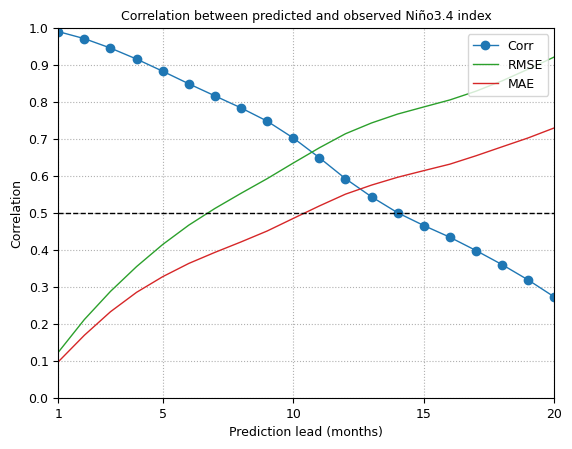

In [9]:
ax1 = plt.subplot(111)
ax1.plot(corr,'-o' ,color="C0", linewidth=1, label="Corr")
ax1.plot(mse ** 0.5, color="C2", linestyle="-", linewidth=1, label="RMSE")
ax1.plot(mae, color="C3", linestyle="-", linewidth=1, label="MAE")
ax1.plot(np.ones(lead_max) * 0.5, color="k", linestyle="--", linewidth=1)
ax1.set_xlim(0, lead_max - 1)
ax1.set_xticks(np.array([1, 5, 10, 15, 20]) - 1)
# ax1.xaxis.set_minor_locator(MultipleLocator(1))
ax1.set_xticklabels(np.array([1, 5, 10, 15, 20]), fontsize=9)
ax1.set_xlabel("Prediction lead (months)", fontsize=9)

ax1.set_ylim(0, 1)
ax1.set_yticks(np.arange(0, 1.01, 0.1))
ax1.set_yticklabels(np.around(np.arange(0, 1.01, 0.1), 1), fontsize=9)
ax1.grid(linestyle=":")
ax1.set_ylabel("Correlation", fontsize=9)
ax1.legend(loc="upper right", fontsize=9)
ax1.set_title("Correlation between predicted and observed Niño3.4 index", fontsize=9)
plt.savefig("./figure/fig_corr.png", dpi=300, bbox_inches="tight")

In [10]:
lead_max = 20
cut_var_true_jx = deepcopy(var_true[(24 - lead_max + 1) :])
cut_var_pred_jx = deepcopy(var_pre[:, (24 - lead_max + 1) :])
# for i in range(20):
#     preds = nino_pre[:,i]
#     trues = nino_true[i:i+20]
# bb = runmean(cut_var_true_jx, 3)
corr = []
mse = []
mae = []

# for l in range(lead_max):
#     aa = runmean(cut_var_pred_jx[l], 3)
#     # corr[l] = np.corrcoef(aa, bb)[0, 1]
#     # mse[l] = mean_squared_error(aa, bb)
#     # mae[l] = mean_absolute_error(aa, bb)
#     print(aa.shape)
cut_var_pred_jx.shape, cut_var_true_jx.shape

((20, 468, 9, 51, 120), (468, 9, 51, 120))

In [14]:
lat_mean_pred = np.nanmean(cut_var_pred_jx, axis=-2)
lat_mean_true = np.nanmean(cut_var_true_jx, axis=-2)
lat_mean_pred.shape, lat_mean_true.shape

((20, 468, 9, 120), (468, 9, 120))

In [15]:
corrs_lat_mean = []
for i in range(lead_max):
    corrs_lat = field_corr(lat_mean_pred[i], lat_mean_true)
    corrs_lat_mean.append(corrs_lat)
corrs_lat_mean = np.array(corrs_lat_mean)
corrs_lat_mean.shape

(20, 9, 120)

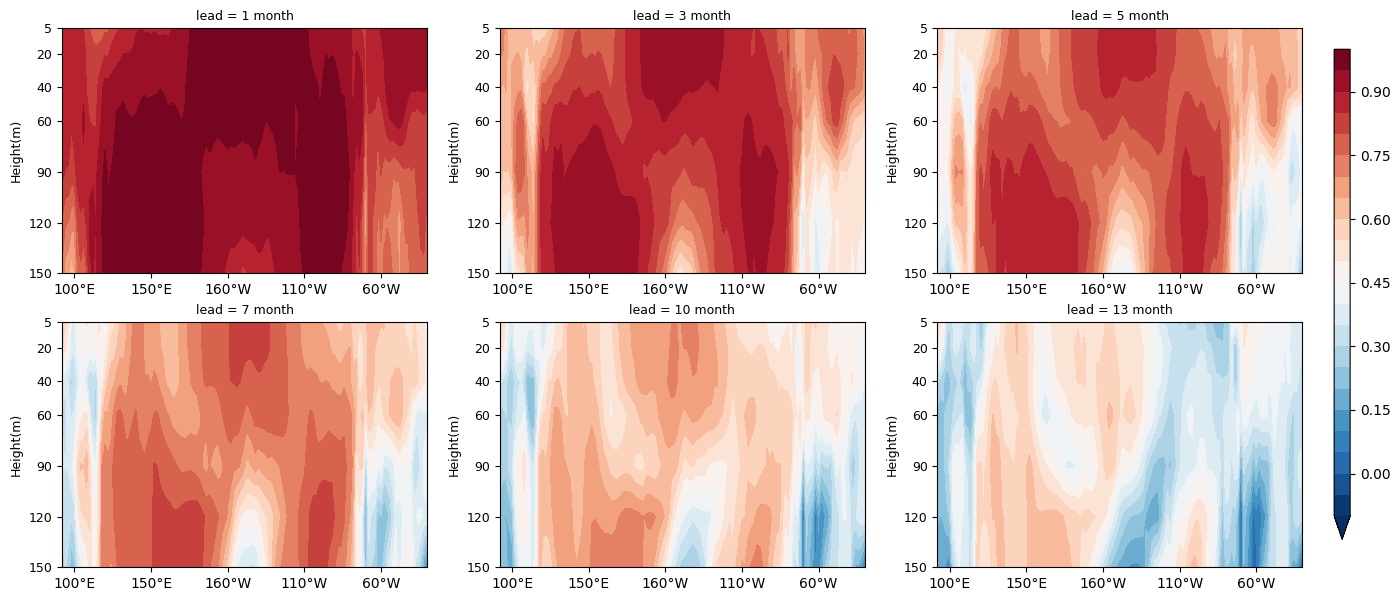

In [36]:
fig = plt.figure(figsize=(16, 7))
idx = 0
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

lon = np.arange(2,359,2)[45:165]
height = [5.,  20.,  40.,  60.,  90., 120., 150.]
for i in [0, 2,4,6,9, 12]:
    idx = idx + 1
    # plt.plot(corrs_lat_mean[i], label=str(i + 1))
    ax = fig.add_subplot(2, 3, idx)
    m = ax.contourf(lon,height,corrs_lat_mean[i,2:], levels=np.arange(-0.1, 1+0.01, 0.05), cmap="RdBu_r",extend='min')
    ax.invert_yaxis()
    # ax.set_yscale("exp")
    ax.set_yticks([5, 20, 40, 60, 90, 120, 150])
    ax.set_yticklabels([5, 20, 40, 60, 90, 120, 150], fontsize=9)
    ax.set_title("lead = " + str(i + 1) + ' month', fontsize=9)
    ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
    ax.set_ylabel("Height(m)", fontsize=9)
    # ax.set_xticks
ax_bar = fig.add_axes([0.92, 0.15, 0.01, 0.7])
cbar = fig.colorbar(m, cax=ax_bar)
    # plt.show()
plt.savefig("./figure/fig_corr_latmean_temp.png", dpi=300, bbox_inches="tight")

In [11]:
corrs = []
for l in range(lead_max):
    pre = cut_var_pred_jx[l]
    obs = cut_var_true_jx
    corr = field_corr(pre, obs)
    corrs.append(corr)

In [ ]:
corrs1 = np.array(corrs)
corrs1.shape

: 

In [ ]:
# corrs1 = np.array(corrs)
# plt.contourf(corrs1[0,0])
# plt.colorbar()
import cartopy.crs as ccrs
import sacpy.Map
def init_map(fig,idx):
    ax = fig.add_subplot(3,3,idx,projection=ccrs.PlateCarree(central_longitude=180))
    # ax.coastlines()
    # ax.set_aspect("auto")
    return ax

lon = np.arange(2,359,2)[45:165]
# lat = np.arange(-20,20+1,1)
lat = np.array( [-20. , -19. , -18. , -17. , -16. , -15. , -14. , -13. , -12. , -11. ,
       -10. ,  -9. ,  -8. ,  -7. ,  -6. ,  -5. ,  -4.5,  -4. ,  -3.5,  -3. ,
        -2.5,  -2. ,  -1.5,  -1. ,  -0.5,   0. ,   0.5,   1. ,   1.5,   2. ,
         2.5,   3. ,   3.5,   4. ,   4.5,   5. ,   6. ,   7. ,   8. ,   9. ,
        10. ,  11. ,  12. ,  13. ,  14. ,  15. ,  16. ,  17. ,  18. ,  19. ,
        20. ])

titles = [
    'taux','tauy'
]
for i in [5.,  20.,  40.,  60.,  90., 120., 150.]:
    titles.append("temperature level:"+str(i)+'m')
for i in range(20):
    fig = plt.figure(figsize=(15, 10))
    # fig.sub
    fig.suptitle(f'lead time = {i+1} month', fontsize=12)
    for j in range(9):
        # ax = fig.add_subplot(3,3, j + 1)
        ax = init_map(fig,j+1)
        m = ax.scontourf(lon,lat,corrs1[i, j],levels=np.arange(-0.1,1+0.01,0.1),cmap="RdYlBu_r", transform=ccrs.PlateCarree(),         extend='min')
        ax.init_map(stepx=60,stepy=5)
        # ax.sig_plot(lon,lat,1 - corrs1[i, j],thrshd=0.5)
        ax.set_title(titles[j],fontsize=9)
    ax_bar = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(m, cax=ax_bar)
    # ax_bar.set_ylabel('Correlation', fontsize=9)
        # plt.colorbar(m)
        # n = ax.contour(corrs1[i, j],levels=[0,0.5],colors="gray", transform=ccrs.PlateCarree())
    # plt.show()
    plt.savefig(f"./figure/fig_corr_{i+1}month.png", dpi=300, bbox_inches="tight")
    plt.show()

: 

In [ ]:
lon.shape, lat.shape,corrs1.shape

: 

In [ ]:
corrs1.shape

: 